This program was created exclusively for the course "Advanced Space 
Propulsion" at FH Aachen University of Applied Sciences
by Prof. Dr. Bernd Dachwald on 13 November 2021.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Please enter user input into the next cell

In [2]:
m_0    = 1000.0   # Initial S/C mass in [kg]
m_p    = 150.0    # Propellant mass in [kg]
thrust = 1.0      # Thrust in [N]
Isp    = 4000.0   # Specific impulse in [s]
alpha  = 90.0     # Thrust angle in [°]
h_0    = 200.0    # Initial altitude in [km]
tint   = 60.0     # Integration time in days
points = 43200.0  # Number of output points

#### General Constants for the problem

In [3]:
mu = 398600.4  # Gravitational parameter of the Earth in [km^3/s^2]
R  = 6378.14   # Earth radius in [km]
g0 = 9.80665   # Earth standard gravitational acceleration in [m/s^2]

#### Convert input into "correct" units

In [4]:
alpha = np.deg2rad(alpha)  # Convert thrust angle to [rad]
thrust = thrust / 1000.0   # Convert thrust to [kg*km/s^2]
ceff = Isp * g0 / 1000.0   # Effective exhaust velocity in [km/s]
tmax = tint * 86400        # Convert integration time to [s]

#### Initial values

In [5]:
r_0       = R + h_0        # Initial orbit radius in [km]
v_0       = (mu/r_0)**0.5  # Initial velocity in [km/s]
phi_0     = 0.0            # Initial orbit angle [rad]
rho_r_0   = 0.0            # Initial radial velocity in [km/s]
rho_phi_0 = v_0 / r_0      # Initial angular velocity in [rad/s]

Note that $v_0 = \sqrt{\frac{\mu}{r_0^3}}$ and $\dot\varphi_0 = \frac{v_0}{r_0}$

#### Equations of motion (EOM)

\begin{align*}
\dot r &= \rho_r\\
\dot \varphi  &= \rho_\varphi\\
\dot\rho_r &= r \rho_\varphi^2 - \frac{\mu}{r^2} + \frac{F_T}{m}\cos\alpha\\
\dot\rho_\varphi &= \frac{1}{r}\left(\frac{F_T}{m}\sin\alpha - 2\rho_r \rho_\varphi\right)\\
\dot m &= -\frac{F_T}{c}\\
\end{align*}

In [6]:
def eom(t, state, thrust, ceff, mdry):
    r, phi, rhor, rhophi, m = state
    
    # Bang-bang control
    if (m > mdry):
        throttle = 1.0
    else:
        throttle = 0.0
    
    dr      = rhor
    dphi    = rhophi
    drhor   = r * rhophi**2 - mu / r**2 + throttle * thrust / m * np.cos(alpha)
    drhophi = 1 / r * (throttle * thrust / m * np.sin(alpha) - 2 * rhor * rhophi)
    dm = - throttle * thrust / ceff
    
    return [dr, dphi, drhor, drhophi, dm]

##### Prepare EOM

In [7]:
init_val  = [r_0, phi_0, rho_r_0, rho_phi_0, m_0]  # List with all initial conditions
p = (thrust, ceff, m_0 - m_p)  # Array with all S/C parameters
t = np.arange(0.0, tmax, tmax / points)  # Simulation time range

##### Solve EOM

In [8]:
trajectory = solve_ivp(eom, (0.0, tmax), init_val, args=p, method='DOP853', rtol=1e-12, atol=1e-9, t_eval=t)

##### Convert trajectory from (r,phi) to (x,y) ... and more

In [9]:
r      = trajectory.y[0, :]
phi    = trajectory.y[1, :]
rdot   = trajectory.y[2, :]
phidot = trajectory.y[3, :]
m      = trajectory.y[4, :]
x = r * np.cos(phi)       # x-coordinate in [km]
y = r * np.sin(phi)       # y-coordinate in [km]
vr = rdot                 # Radial velocity in [km/s]
vt = r * phidot           # Transversal velocity in [km/s]
v = (vr**2 + vt**2)**0.5  # Velocity in [km/s]
E = 0.5 * v**2 - mu / r   # Orbital energy in [MJ/kg]
a = - mu / (2 * E)        # Semi-major axis in [km]
h = r**2 * phidot         # Orbital angular momentum in [km^2/s]
e = (np.abs(1 - h**2 / (mu * a)))**0.5  # Eccentricity
# Note: absolute value because for e close to 0, 1 - h^2 / (mu * a) can
# become negative due to rounding errors -> runtime warning

#### Print propellant consumption

In [10]:
print("Propellant required for %f days of thrusting is %f kg" %(tint, thrust / ceff * tmax))
print("Propellant consumed was %f kg" %(m_0 - m[-1]))

Propellant required for 60.000000 days of thrusting is 132.155221 kg
Propellant consumed was 132.152162 kg


#### Plot trajectory

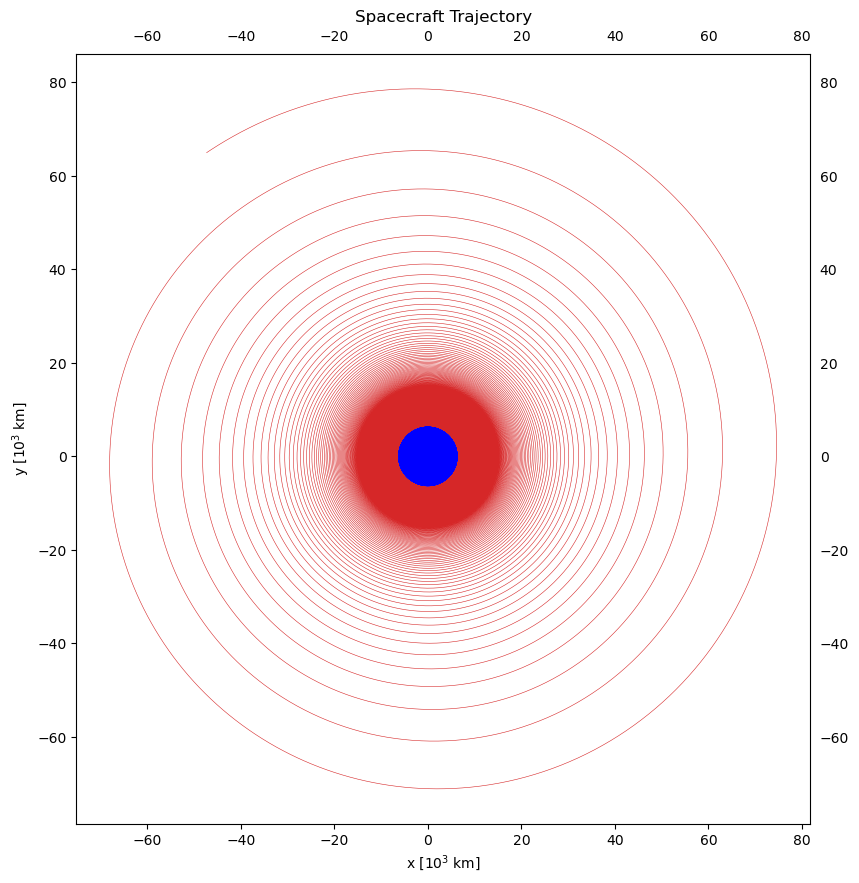

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
ax.plot(x / 1000.0, y / 1000.0, 'tab:red', linewidth=0.4)
ax.tick_params(labeltop = True, labelright = True)
ax.set_aspect('equal')
earth = plt.Circle((0, 0), R / 1000.0, color='blue')
ax.add_patch(earth)
plt.title("Spacecraft Trajectory")
plt.xlabel("x [$10^3$ km]")
plt.ylabel("y [$10^3$ km]")
plt.show()

#### Plot panel of values

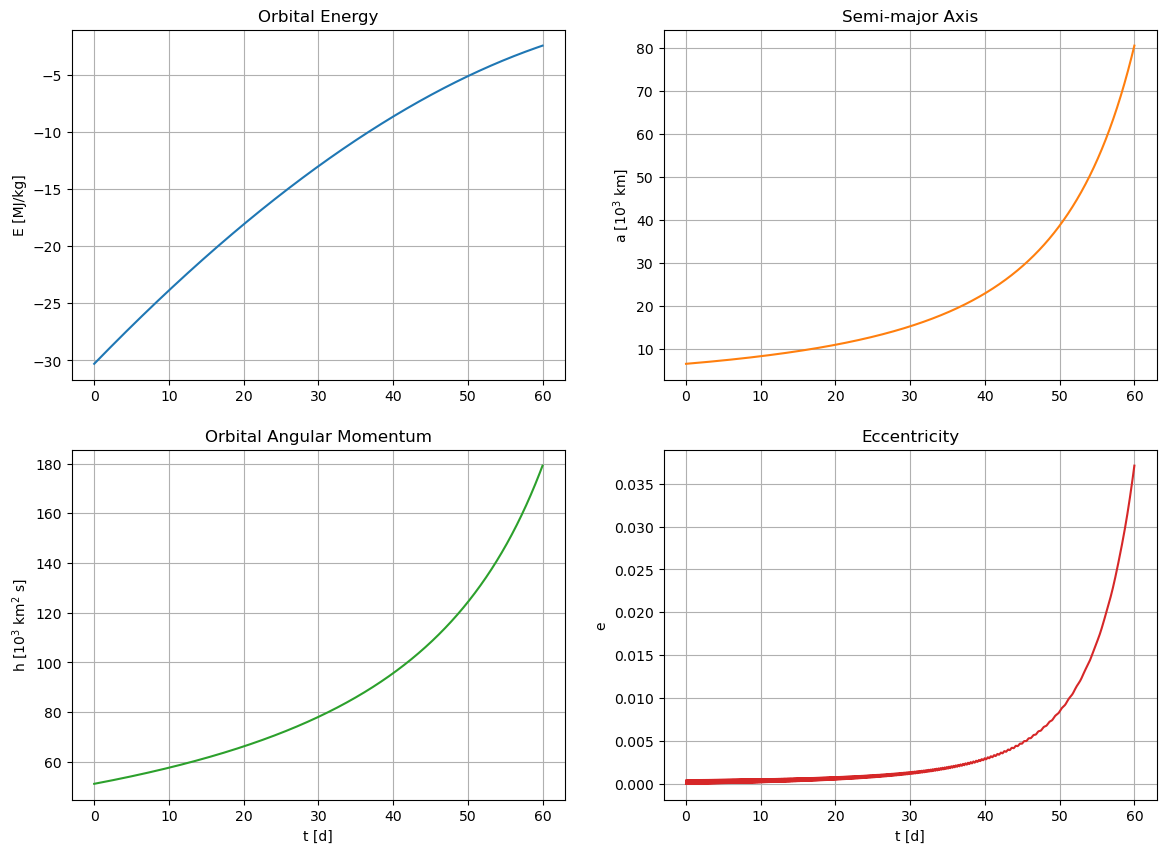

In [12]:
plt.rcParams["figure.figsize"] = (14,10)
fig, axs = plt.subplots(2,2)

axs[0,0].plot(t / 86400, E)  # Orbital energy
axs[0,0].grid()
axs[0,0].set_title("Orbital Energy")
axs[0,0].set(ylabel="E [MJ/kg]")

axs[0,1].plot(t / 86400, a / 1e3, 'tab:orange')  # Semi-major axis
axs[0,1].grid()
axs[0,1].set_title("Semi-major Axis")
axs[0,1].set(ylabel="a [$10^3$ km]")

axs[1,0].plot(t / 86400, h / 1e3, 'tab:green')  # Orbital angular momentum
axs[1,0].grid()
axs[1,0].set_title("Orbital Angular Momentum")
axs[1,0].set(xlabel="t [d]", ylabel="h [$10^3$ km${}^2$ s]")

axs[1,1].plot(t / 86400, e, 'tab:red')  # Eccentricity
axs[1,1].grid()
axs[1,1].set_title("Eccentricity")
axs[1,1].set(xlabel="t [d]", ylabel="e")

plt.show()